## 无锚模型

意味着它直接预测对象的中心，而不是已知锚框的偏移量。

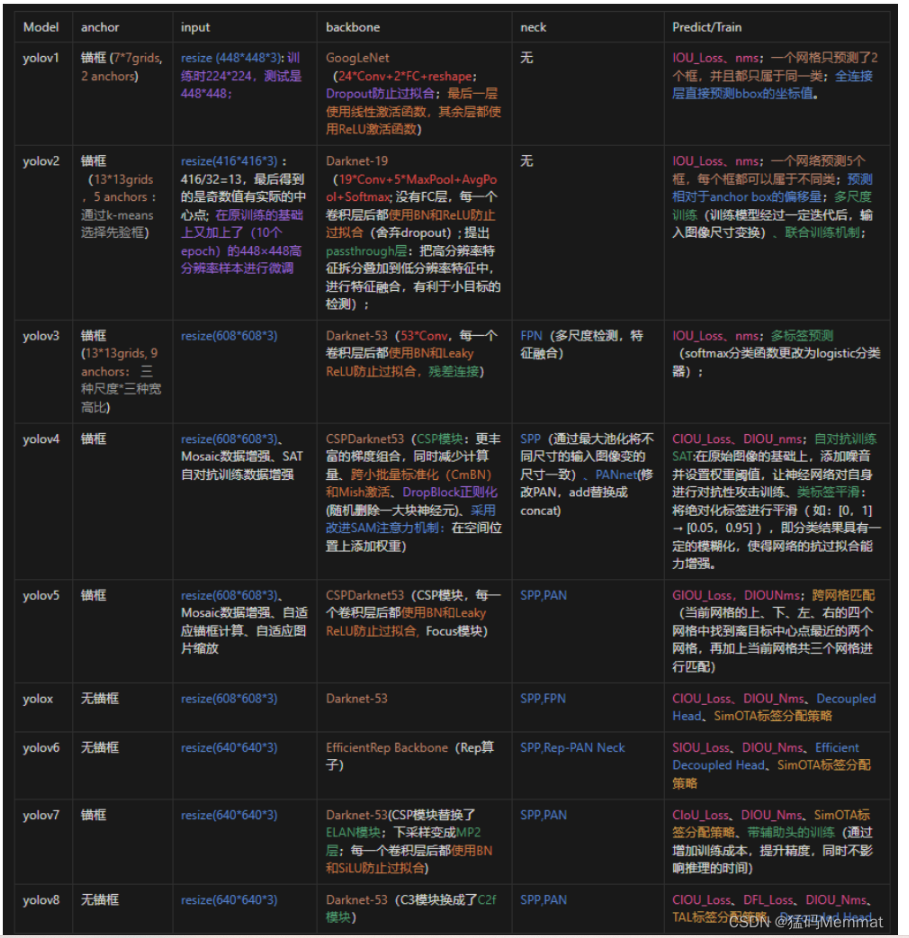

## 训练过程中数据增强

YOLOv8 在在线训练期间增强图像。在每个时期，模型看到的图像与所提供的图像略有不同。训练的数据增强部分引入了 YOLOX 中的最后 10 epoch 关闭 Mosiac 增强的操作，可以有效地提升精度。

马赛克增强：

    这涉及将四张图像拼接在一起，迫使模型学习新位置、部分遮挡以及针对不同周围像素的对象。（经验表明，如果在整个训练过程中进行这种增强，则会降低性能。在最后十个训练周期中关闭它是有利的。）

## 对比yolov5

    1、用户友好的 API（命令行 + Python）
    2、更快更准确
    3、支持
        物体检测
        实例分割
        图像分类
    4、可扩展到所有以前的版本
    5、新骨干网络
        YOLOv5中的C3替换为更精简的C2f ，即增加了更多的跳跃连接和split操作（不过这个 C2f 模块中存在 Split 等操作对特定硬件部署没有之前那么友好了）；
    6、新的 Anchor-Free head
        耦合头变成了解耦头（yolox的Decoupled Head，不过从3个分支变成两个分支）；不再有之前的 objectness 分支，只有解耦的分类和回归分支，并且其回归分支使用了 Distribution Focal Loss 中提出的积分形式表示法。
        同时也从 Anchor-Based 换成了 Anchor-Free；
        


## SPPF

参考链接： https://blog.csdn.net/weixin_38346042/article/details/131796263

SPP结构：又称空间金字塔池化，能够将能将任意大小的特征图转换成固定大小的特征向量。

SPP（Spatial Pyramid Pooling）是一种池化层，它允许网络处理不同尺度的输入图像，从而提高了模型对尺度变化的适应能力。SPP的主要思想是将输入图像划分为多个区域，对每个区域进行池化，最后将所有池化结果合并在一起。

SPP(yolov3):SPP（Spatial Pyramid Pooling 四种最⼤池化⽅式，1x1; 5x5; 9x9; 13x13） 

    SPP是一种在卷积神经网络（CNN）中广泛使用的池化层。
    它允许网络处理不同尺寸的输入图像，从而提高了模型对尺寸变化的适应能力。
    SPP将输入图像划分为多个区域，对每个区域进行池化，然后将所有池化结果合并在一起。
    SPP 模块是何凯大神在2015年的论文《Spatial Pyramid Pooling in Deep Convolution Networks for Visual Recognition》中提出来的.

    SPP全称为空间金字塔池化结构，主要是为了解决两个问题：
        1、有效避免了对图像区域的裁剪、缩放操作导致的图像失真等问题。
        2、解决了卷积神经网络对图相关重复特征提取的问题，大大提高了产生候选框的速度，且节省了计算成本
SPPF(YOLOv8, yolov5):

    这个是Yolov5作者基于SPP提出的，速度较SPP快很多（2.5倍），所以叫做SPP-Fast
    SPPF结构是将输入串行通过多个5x5大小的MaxPool层，这里需要注意的是串行两个5x5大小的MaxPool层是和一个9x9大小的MaxPool层计算结果是一样的，串行三个5x5大小的MaxPool层是和一个13x13大小的MaxPool层计算结果是一样的。
    SPPF结构与SPP结构作用一样，但SPPF结构效率更高、速度更快

SimSPPF(美团yolov6):
   
    美团YOLOv6提出的模块，感觉和SPPF只差了一个激活函数，简单测试了一下，单个ConvBNReLU速度比ConvBNSiLU快18%。
    SimSPPF是对传统的SPPF的改进，它引入了“同时池化”的概念。
    传统的SPPF需要对每个区域进行独立的池化操作，而SimSPPF可以同时对所有区域进行池化，从而进一步提升了计算速度。


In [4]:
class SPP(nn.Module):
    # Spatial Pyramid Pooling (SPP) layer https://arxiv.org/abs/1406.4729
    def __init__(self, c1, c2, k=(5, 9, 13)):
        super().__init__()
        c_ = c1 // 2  # hidden channels
        self.cv1 = Conv(c1, c_, 1, 1)
        self.cv2 = Conv(c_ * (len(k) + 1), c2, 1, 1)
        self.m = nn.ModuleList([nn.MaxPool2d(kernel_size=x, stride=1, padding=x // 2) for x in k])

    def forward(self, x):
        x = self.cv1(x)
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')  # suppress torch 1.9.0 max_pool2d() warning
            return self.cv2(torch.cat([x] + [m(x) for m in self.m], 1))



In [5]:
class SPPF(nn.Module):
    # Spatial Pyramid Pooling - Fast (SPPF) layer for YOLOv5 by Glenn Jocher
    def __init__(self, c1, c2, k=5):  # equivalent to SPP(k=(5, 9, 13))
        super().__init__()
        c_ = c1 // 2  # hidden channels
        self.cv1 = Conv(c1, c_, 1, 1)
        self.cv2 = Conv(c_ * 4, c2, 1, 1)
        self.m = nn.MaxPool2d(kernel_size=k, stride=1, padding=k // 2)

    def forward(self, x):
        x = self.cv1(x)
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')  # suppress torch 1.9.0 max_pool2d() warning
            y1 = self.m(x)
            y2 = self.m(y1)
            return self.cv2(torch.cat((x, y1, y2, self.m(y2)), 1))



## 损失函数
    YOLOv8抛弃了以往的IOU匹配或者单边比例的分配方式，而是使用了Task-Aligned Assigner正负样本匹配方式。

    并引入了 Distribution Focal Loss(DFL)。
Loss 计算过程包括 2 个部分： 正负样本分配策略和 Loss 计算。

1、 正负样本分配策略

现代目标检测器大部分都会在正负样本分配策略上面做文章，典型的如 YOLOX 的 simOTA、TOOD 的 TaskAlignedAssigner 和 RTMDet 的 DynamicSoftLabelAssigner，这类 Assigner 大都是动态分配策略，而 YOLOv5 采用的依然是静态分配策略。考虑到动态分配策略的优异性，YOLOv8 算法中则直接引用了 TOOD 的 TaskAlignedAssigner。

TaskAlignedAssigner 的匹配策略简单总结为： 根据分类与回归的分数加权的分数选择正样本。

2、Loss计算

Loss 计算包括 2 个分支： 分类和回归分支，没有了之前的 objectness 分支。

分类分支依然采用 BCE Loss

回归分支需要和 Distribution Focal Loss 中提出的积分形式表示法绑定，因此使用了 Distribution Focal Loss， 同时还使用了 CIoU Loss。3 个 Loss 采用一定权重比例加权即可。回归分支使用了 Distribution Focal Loss（DFL Reg_max默认为16）+ CIoU Loss。



## yolov5中的静态匹配策略
在 YOLOv5 中，静态匹配策略是指在训练过程中，将目标框（ground truth boxes）与预测框（predicted boxes）进行匹配以计算损失的策略。

具体来说，YOLOv5使用以下静态匹配策略：

Anchor 匹配：首先，将每个目标框与锚框进行比较，并选择与之最匹配的锚框作为预测框的参考。匹配的标准可以是两者的 IoU（交并比）值。

预测框分配：每个目标框只会被分配到一个锚框上，而每个锚框也只会负责预测与之最匹配的目标框。

未匹配的预测框：如果一个预测框没有与之匹配的目标框，它会被视为负样本，对应的分类损失和目标损失会被抑制。

类别平滑（Class Label Smoothing）：在分类损失的计算中，采用了类别平滑技巧，以减少过拟合。

总的来说，静态的匹配策略在训练中用于将目标框与预测框进行关联，并计算相应的损失，从而指导网络学习目标检测任务。

YOLOv6 沿用了 YOLOX的SimOTA算法动态分配正样本，进一步提高检测精度

## LetterBox数据增强
就是yolov5的⾃适应图⽚缩放

 LetterBox是一种数据增强方法，它可以将图像缩放到指定大小(长和宽等比例缩放)，然后在图像的两侧添加黑色边框，使其大小和要调整的大小一致。这种方法可以保留原始图像的纵横比，同时还可以使图像更加适合目标检测算法的输入。
        首先将图片按比例缩放，将较长的边缩放到设定的尺寸以后，再将较短的边进行填充，最终短边的长度为stride的倍数即可

## TaskAlignedAssigner

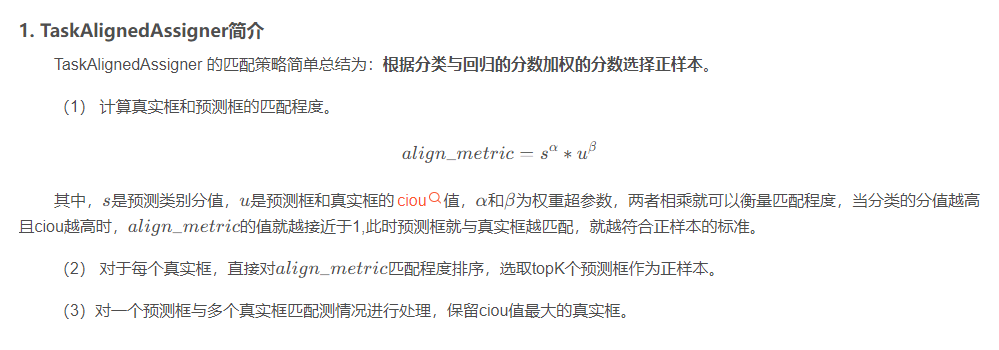

In [2]:

import torch # pytorch的版本最低为 1.10
import torch.nn as nn
import torch.nn.functional as F
import math

def select_candidates_in_gts(xy_centers, gt_bboxes, eps=1e-9):
    """select the positive anchor center in gt

    Args:
        xy_centers (Tensor): shape(h*w, 2)
        gt_bboxes (Tensor): shape(b, n_boxes, 4)
    Return:
        (Tensor): shape(b, n_boxes, h*w)
    """
    n_anchors = xy_centers.shape[0]
    bs, n_boxes, _ = gt_bboxes.shape

    lt, rb = gt_bboxes.view(-1, 1, 4).chunk(2, 2)  # left-top, right-bottom
    bbox_deltas = torch.cat((xy_centers[None] - lt, rb - xy_centers[None]), dim=2).view(bs, n_boxes, n_anchors, -1)
    # return (bbox_deltas.min(3)[0] > eps).to(gt_bboxes.dtype)
    # torch.amin(input, dim, keepdim=False, *, out=None) → Tensor 返回给定维度 dim 中 input 张量的每个切片的最小值。
    return bbox_deltas.amin(3).gt_(eps)


def select_highest_overlaps(mask_pos, overlaps, n_max_boxes):
    """if an anchor box is assigned to multiple gts,
        the one with the highest iou will be selected.

    Args:
        mask_pos (Tensor): shape(b, n_max_boxes, h*w)
        overlaps (Tensor): shape(b, n_max_boxes, h*w)
    Return:
        target_gt_idx (Tensor): shape(b, h*w)
        fg_mask (Tensor): shape(b, h*w)
        mask_pos (Tensor): shape(b, n_max_boxes, h*w)
    """
    # 一个预测框匹配真实框的个数
    # (b, n_max_boxes, h*w) -> (b, h*w)
    fg_mask = mask_pos.sum(-2)

    # 如果一个预测框匹配真实框的个数 > 1
    if fg_mask.max() > 1:  # one anchor is assigned to multiple gt_bboxes
        # 一个预测框匹配多个真实框的位置
        mask_multi_gts = (fg_mask.unsqueeze(1) > 1).repeat([1, n_max_boxes, 1])  # (b, n_max_boxes, h*w)

        # 与预测框IoU值最高的真实框的索引
        max_overlaps_idx = overlaps.argmax(1)  # (b, h*w)
        # 进行one-hot编码，与预测框IoU值最高的真实框的位置为 1 
        is_max_overlaps = F.one_hot(max_overlaps_idx, n_max_boxes)  # (b, h*w, n_max_boxes)
        is_max_overlaps = is_max_overlaps.permute(0, 2, 1).to(overlaps.dtype)  # (b, n_max_boxes, h*w)
        
        mask_pos = torch.where(mask_multi_gts, is_max_overlaps, mask_pos)  # (b, n_max_boxes, h*w)
        
        # 正样本的mask
        fg_mask = mask_pos.sum(-2)

    # 每个正样本与之匹配真实框的索引
    # find each grid serve which gt(index)
    target_gt_idx = mask_pos.argmax(-2)  # (b, h*w)

    return target_gt_idx, fg_mask, mask_pos


class TaskAlignedAssigner(nn.Module):

    def __init__(self, topk=13, num_classes=80, alpha=1.0, beta=6.0, eps=1e-9):
        super().__init__()
        self.topk = topk # 每个gt box最多选择topk个候选框作为正样本
        self.num_classes = num_classes
        self.bg_idx = num_classes
        self.alpha = alpha
        self.beta = beta
        self.eps = eps

    @torch.no_grad()
    def forward(self, pd_scores, pd_bboxes, anc_points, gt_labels, gt_bboxes, mask_gt):
        """This code referenced to
           https://github.com/Nioolek/PPYOLOE_pytorch/blob/master/ppyoloe/assigner/tal_assigner.py

        Args:
            pd_scores (Tensor): shape(bs, num_total_anchors, num_classes)
            pd_bboxes (Tensor): shape(bs, num_total_anchors, 4)
            anc_points (Tensor): shape(num_total_anchors, 2)
            gt_labels (Tensor): shape(bs, n_max_boxes, 1)
            gt_bboxes (Tensor): shape(bs, n_max_boxes, 4)
            mask_gt (Tensor): shape(bs, n_max_boxes, 1)
        Returns:
            target_labels (Tensor): shape(bs, num_total_anchors)
            target_bboxes (Tensor): shape(bs, num_total_anchors, 4)
            target_scores (Tensor): shape(bs, num_total_anchors, num_classes)
            fg_mask (Tensor): shape(bs, num_total_anchors)
        """

        # batch size 的大小
        self.bs = pd_scores.size(0)
        # 每个图片真实框个数不同，按图片中真实框最大的个数进行补零对齐。
        # n_max_boxes：最大真实框的个数
        self.n_max_boxes = gt_bboxes.size(1)

        # 如果不存在真实框，直接返回结果
        if self.n_max_boxes == 0:
            device = gt_bboxes.device
            return (torch.full_like(pd_scores[..., 0], self.bg_idx).to(device), torch.zeros_like(pd_bboxes).to(device),
                    torch.zeros_like(pd_scores).to(device), torch.zeros_like(pd_scores[..., 0]).to(device),
                    torch.zeros_like(pd_scores[..., 0]).to(device))
        
        # 真实框的mask，正负样本的匹配程度，正负样本的IoU值
        mask_pos, align_metric, overlaps = self.get_pos_mask(pd_scores, pd_bboxes, gt_labels, gt_bboxes, anc_points,
                                                             mask_gt)
        # 对一个正样本匹配多个真实框的情况进行调整
        target_gt_idx, fg_mask, mask_pos = select_highest_overlaps(mask_pos, overlaps, self.n_max_boxes)

        # assigned target 
        target_labels, target_bboxes, target_scores = self.get_targets(gt_labels, gt_bboxes, target_gt_idx, fg_mask)

        # normalize
        align_metric *= mask_pos
        pos_align_metrics = align_metric.amax(axis=-1, keepdim=True)  # b, max_num_obj
        pos_overlaps = (overlaps * mask_pos).amax(axis=-1, keepdim=True)  # b, max_num_obj
        norm_align_metric = (align_metric * pos_overlaps / (pos_align_metrics + self.eps)).amax(-2).unsqueeze(-1)
        target_scores = target_scores * norm_align_metric

        return target_labels, target_bboxes, target_scores, fg_mask.bool(), target_gt_idx

    def get_pos_mask(self, pd_scores, pd_bboxes, gt_labels, gt_bboxes, anc_points, mask_gt):

        # 预测框和真实框的匹配程度、预测框和真实框的IoU值
        # get anchor_align metric, (b, max_num_obj, h*w)
        align_metric, overlaps = self.get_box_metrics(pd_scores, pd_bboxes, gt_labels, gt_bboxes)

        # 筛选锚点在真实框内的预测框
        # get in_gts mask, (b, max_num_obj, h*w)
        mask_in_gts = select_candidates_in_gts(anc_points, gt_bboxes)

        # get topk_metric mask, (b, max_num_obj, h*w)
        # 由于为了使每张图片真实框的数量进行对齐，进行了补 0 操作，mask_gt 用于确定有效真实框
        mask_topk = self.select_topk_candidates(align_metric * mask_in_gts,
                                                topk_mask=mask_gt.repeat([1, 1, self.topk]).bool())
        
        # merge all mask to a final mask, (b, max_num_obj, h*w)
        mask_pos = mask_topk * mask_in_gts * mask_gt

        return mask_pos, align_metric, overlaps

    def get_box_metrics(self, pd_scores, pd_bboxes, gt_labels, gt_bboxes):

        ind = torch.zeros([2, self.bs, self.n_max_boxes], dtype=torch.long)  # 2, b, max_num_obj
        ind[0] = torch.arange(end=self.bs).view(-1, 1).repeat(1, self.n_max_boxes)  # b, max_num_obj
        ind[1] = gt_labels.long().squeeze(-1)  # b, max_num_obj
        # get the scores of each grid for each gt cls
        # pd_scores[ind[0]] 将每个batch的生成的预测框的重复 max_num_obj 次 size 大小变为 b*max_num_obj*num_total_anchors*num_classes
        # bbox_scores 的 size 为 b*max_num_obj*num_total_anchors，ind[1] 对类别进行得分进行选取
        bbox_scores = pd_scores[ind[0], :, ind[1]]  # b, max_num_obj, num_total_anchors

        # overlaps 的 size 为 b*max_num_obj*num_total_anchors
        # gt_bboxes.unsqueeze(2) 的 size 为 b*max_num_obj*1*4
        # pd_bboxes.unsqueeze(1) 的 size 为 b*1*num_total_anchors*4
        # bbox_iou 的计算结果 的 size 为 b*max_num_obj*num_total_anchors*1，所以进行维度的压缩
        overlaps = bbox_iou(gt_bboxes.unsqueeze(2), pd_bboxes.unsqueeze(1), xywh=False,
                            CIoU=True).squeeze(3).clamp(0)
        # 预测框和真实框的匹配程度 = 预测类别分值**alpha × 预测框和真实框的ciou值**beta
        align_metric = bbox_scores.pow(self.alpha) * overlaps.pow(self.beta)

        return align_metric, overlaps

    def select_topk_candidates(self, metrics, largest=True, topk_mask=None):
        """
        Args:
            metrics: (b, max_num_obj, h*w).
            topk_mask: (b, max_num_obj, topk) or None
        """

        num_anchors = metrics.shape[-1]  # h*w

        # 第一个值为排序的数组，第二个值为该数组中获取到的元素在原数组中的位置标号。
        topk_metrics, topk_idxs = torch.topk(metrics, self.topk, dim=-1, largest=largest)

        # 如果没有给出有效真实框的mask，通过真实框和预测框的匹配程度确定真实框的有效性
        if topk_mask is None:
            topk_mask = (topk_metrics.max(-1, keepdim=True) > self.eps).tile([1, 1, self.topk])

        # 如果真实框是无效的，将与之匹配的正样本索引值置为 0
        # (b, max_num_obj, topk)
        topk_idxs[~topk_mask] = 0

        # 将索引值进行 one-hot 编码
        is_in_topk = F.one_hot(topk_idxs, num_anchors).sum(-2)

        # 过滤无效值
        # filter invalid bboxes
        is_in_topk = torch.where(is_in_topk > 1, 0, is_in_topk)

        return is_in_topk.to(metrics.dtype)

    def get_targets(self, gt_labels, gt_bboxes, target_gt_idx, fg_mask):
        """
        Args:
            gt_labels: (b, max_num_obj, 1)
            gt_bboxes: (b, max_num_obj, 4)
            target_gt_idx: (b, h*w)
            fg_mask: (b, h*w)
        """

        # assigned target labels, (b, 1)
        batch_ind = torch.arange(end=self.bs, dtype=torch.int64, device=gt_labels.device)[..., None]
        target_gt_idx = target_gt_idx + batch_ind * self.n_max_boxes  # (b, h*w)
        target_labels = gt_labels.long().flatten()[target_gt_idx]  # (b, h*w)

        # assigned target boxes, (b, max_num_obj, 4) -> (b, h*w)
        target_bboxes = gt_bboxes.view(-1, 4)[target_gt_idx]

        # assigned target scores
        target_labels.clamp(0)
        target_scores = F.one_hot(target_labels, self.num_classes)  # (b, h*w, 80)
        fg_scores_mask = fg_mask[:, :, None].repeat(1, 1, self.num_classes)  # (b, h*w, 80)
        target_scores = torch.where(fg_scores_mask > 0, target_scores, 0)

        return target_labels, target_bboxes, target_scores
        
# IoU，GIoU，DIoU，CIoU的计算这里不作详细解释
def bbox_iou(box1, box2, xywh=True, GIoU=False, DIoU=False, CIoU=False, eps=1e-7):
    # Returns Intersection over Union (IoU) of box1(1,4) to box2(n,4)

    # Get the coordinates of bounding boxes
    if xywh:  # transform from xywh to xyxy
        (x1, y1, w1, h1), (x2, y2, w2, h2) = box1.chunk(4, -1), box2.chunk(4, -1)
        w1_, h1_, w2_, h2_ = w1 / 2, h1 / 2, w2 / 2, h2 / 2
        b1_x1, b1_x2, b1_y1, b1_y2 = x1 - w1_, x1 + w1_, y1 - h1_, y1 + h1_
        b2_x1, b2_x2, b2_y1, b2_y2 = x2 - w2_, x2 + w2_, y2 - h2_, y2 + h2_
    else:  # x1, y1, x2, y2 = box1
        b1_x1, b1_y1, b1_x2, b1_y2 = box1.chunk(4, -1)
        b2_x1, b2_y1, b2_x2, b2_y2 = box2.chunk(4, -1)
        w1, h1 = b1_x2 - b1_x1, b1_y2 - b1_y1 + eps
        w2, h2 = b2_x2 - b2_x1, b2_y2 - b2_y1 + eps

    # Intersection area
    inter = (b1_x2.minimum(b2_x2) - b1_x1.maximum(b2_x1)).clamp(0) * \
            (b1_y2.minimum(b2_y2) - b1_y1.maximum(b2_y1)).clamp(0)

    # Union Area
    union = w1 * h1 + w2 * h2 - inter + eps

    # IoU
    iou = inter / union
    if CIoU or DIoU or GIoU:
        cw = b1_x2.maximum(b2_x2) - b1_x1.minimum(b2_x1)  # convex (smallest enclosing box) width
        ch = b1_y2.maximum(b2_y2) - b1_y1.minimum(b2_y1)  # convex height
        if CIoU or DIoU:  # Distance or Complete IoU https://arxiv.org/abs/1911.08287v1
            c2 = cw ** 2 + ch ** 2 + eps  # convex diagonal squared
            rho2 = ((b2_x1 + b2_x2 - b1_x1 - b1_x2) ** 2 + (b2_y1 + b2_y2 - b1_y1 - b1_y2) ** 2) / 4  # center dist ** 2
            if CIoU:  # https://github.com/Zzh-tju/DIoU-SSD-pytorch/blob/master/utils/box/box_utils.py#L47
                v = (4 / math.pi ** 2) * (torch.atan(w2 / h2) - torch.atan(w1 / h1)).pow(2)
                with torch.no_grad():
                    alpha = v / (v - iou + (1 + eps))
                return iou - (rho2 / c2 + v * alpha)  # CIoU
            return iou - rho2 / c2  # DIoU
        c_area = cw * ch + eps  # convex area
        return iou - (c_area - union) / c_area  # GIoU https://arxiv.org/pdf/1902.09630.pdf
    return iou  # IoU



##  Distribution Focal Loss

参考：https://blog.csdn.net/u012863603/article/details/128816715

背景：目前被广泛使用的bbox表示可以看作是对bbox方框坐标建模了单一的狄拉克分布。**但是在复杂场景中，一些检测对象的边界并非十分明确**。如下图左面所示，对于滑板左侧被水花模糊，引起对左边界的预测分布是任意而扁平的，对右边界的预测分布是明确而尖锐的。对于这个问题，有学者提出直接回归一个任意分布来建模边界框，使用softmax实现离散的回归，将狄拉克分布的积分形式推导到一般形式的积分形式来表示边界框。

狄拉克分布可以认为在一个点概率密度为无穷大，其他点概率密度为0，这是一种极端地认为离散的标签时绝对正确的。

因为标签是一个离散的点，如果把标签认为是绝对正确的目标，那么学习出的就是狄拉克分布，概率密度是一条尖锐的竖线。然而真实场景，物体边界并非是十分明确的，因此学习一个宽范围的分布更为合理。我们需要获得的分布虽然不再像狄拉克分布那么极端（只存在标签值），但也应该在标签值附近。因此学者提出Distribution Focal Loss损失函数，目的让网络快速聚焦到标签附近的数值，是标签处的概率密度尽量大。思想是使用交叉熵函数，来优化标签y附近左右两个位置的概率，是网络分布聚焦到标签值附近。如下公式。Si 是网络的sigmod 输出，yi 和 yi+1 是上图的区间顺序，y是label 值。

    A、训练阶段：我们以回归left为例：目标的label 转换为ltrb后，y = （ left - 匹配到的anchor 中心点 x 坐标）/ 当前的下采样倍数，假设求得3.2。那么i 就应该为3，yi = 3 ,yi+1 = 4。

    B、推理阶段：因为没有label，直接将16个格子进行积分（离散变量为求和，也就是期望）结果就是最终的坐标偏移量（再乘以下采样倍数+ 匹配到的anchor的对应坐标）

 NOTE：作者代码中的超参数Reg_max是写死的——16，如果要修改需要修改源码，如果你的输入是640，最大下采样到20*20，那么16是够用的，如果输入没有resize或者超过了640一定要自己设置这个Reg_max参数，否则如果目标尺寸还大，将无法拟合到这个偏移量。 比如1280*1280的图片，目标1280*960，最大下采样32倍，1280/32/2=20 > 16(除以2是因为是一半的偏移量)，超过了dfl 滑板右侧那个图的范围。至于为什么叫focal loss的变体，有兴趣看一下这个深入理解一下Generalized Focal Loss v1 & v2 - 知乎和大白话 Generalized Focal Loss - 知乎就可以，这里不再赘述是因为，如果先看这些，很容易犯晕，反而抓不住DFL 我认为的重点（离散的分布形式）


In [3]:
class BboxLoss(nn.Module):

    def __init__(self, reg_max, use_dfl=False):
        """Initialize the BboxLoss module with regularization maximum and DFL settings."""
        super().__init__()
        self.reg_max = reg_max
        self.use_dfl = use_dfl

    def forward(self, pred_dist, pred_bboxes, anchor_points, target_bboxes, target_scores, target_scores_sum, fg_mask):
        """IoU loss."""
        weight = target_scores.sum(-1)[fg_mask].unsqueeze(-1)
        iou = bbox_iou(pred_bboxes[fg_mask], target_bboxes[fg_mask], xywh=False, CIoU=True)
        loss_iou = ((1.0 - iou) * weight).sum() / target_scores_sum

        # DFL loss
        if self.use_dfl:
            target_ltrb = bbox2dist(anchor_points, target_bboxes, self.reg_max)
            loss_dfl = self._df_loss(pred_dist[fg_mask].view(-1, self.reg_max + 1), target_ltrb[fg_mask]) * weight
            loss_dfl = loss_dfl.sum() / target_scores_sum
        else:
            loss_dfl = torch.tensor(0.0).to(pred_dist.device)

        return loss_iou, loss_dfl

    @staticmethod
    def _df_loss(pred_dist, target):
        """Return sum of left and right DFL losses."""
        # Distribution Focal Loss (DFL) proposed in Generalized Focal Loss https://ieeexplore.ieee.org/document/9792391
        tl = target.long()  # target left
        tr = tl + 1  # target right
        wl = tr - target  # weight left
        wr = 1 - wl  # weight right
        return (F.cross_entropy(pred_dist, tl.view(-1), reduction='none').view(tl.shape) * wl +
                F.cross_entropy(pred_dist, tr.view(-1), reduction='none').view(tl.shape) * wr).mean(-1, keepdim=True)

## trics 
    单独训练trick或者重点重复概述上述所有trick

    C2f模块、Decoupled-Head、Anchor-Free、BCE Loss作为分类损失 VFL Loss + CIOU Loss作为回归损失、Task-Aligned Assigner匹配方式、最后 10 个 epoch 关闭 Mosaic 的操作。